# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Bias-Variance Tradeoff

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
from numpy.random import randint, choice, normal, shuffle
import pandas as pd

from scipy.special import factorial

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Generate Sample Data

In [3]:
def f(x, max_degree=9):
    taylor = [(-1)**i * x ** e / factorial(e) for i, e in enumerate(range(1, max_degree, 2))]
    return  np.sum(taylor, axis=0)

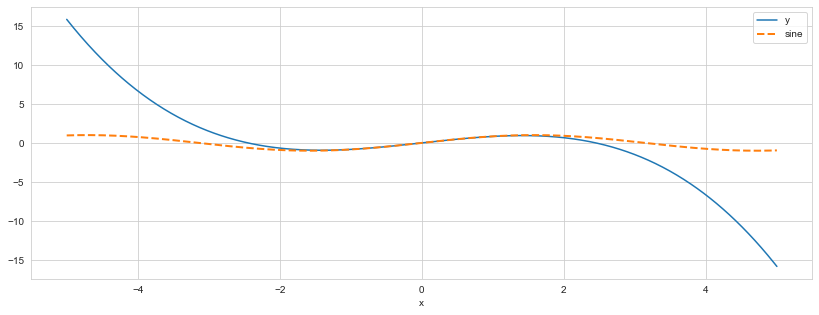

In [4]:
max_degree = 5
fig, ax = plt.subplots(figsize=(14, 5))
x = np.linspace(-5, 5, 1000)

data = pd.DataFrame({'y': f(x, max_degree), 'x': x})
data.plot(x='x', y='y', legend=False, ax=ax)
pd.Series(np.sin(x), index=x).plot(ax=ax, ls='--', lw=2, label='sine')
plt.legend();

## Underfitting vs overfitting: a visual example

In [5]:
from collections import defaultdict

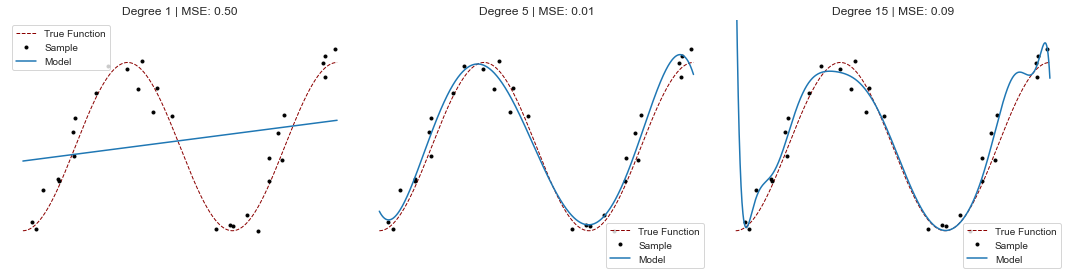

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
x = np.linspace(-.5 * np.pi, 2.5 * np.pi, 1000)
true_function = pd.Series(np.sin(x), index=x)
n = 30
noise = .2
degrees = [1, 5, 15]
x_ = np.random.choice(x, size=n)
y_ = np.sin(x_)
y_ +=  normal(loc=0, scale=np.std(y_) * noise, size=n)
mse = defaultdict(list)
for i, degree in enumerate(degrees):
    fit = np.poly1d(np.polyfit(x=x_, y=y_, deg=degree))
    true_function.plot(ax=axes[i], c='darkred', lw=1, ls='--', label='True Function')
    pd.Series(y_, index=x_).plot(style='.', label='Sample', ax=axes[i], c='k')
    pd.Series(fit(x), index=x).plot(label='Model', ax=axes[i])
    axes[i].set_ylim(-1.5, 1.5)
    mse = mean_squared_error(fit(x), np.sin(x))
    axes[i].set_title(f'Degree {degree} | MSE: {mse:,.2f}')
    axes[i].legend()
    axes[i].grid(False)
    axes[i].axis(False)

sns.despine()
fig.tight_layout();

## Bias-Variance Tradeoff

### Train Model

In [7]:
datasets = ['Train', 'Test']
X = {'Train': np.linspace(-1, 1, 1000), 'Test': np.linspace(1, 2, 500)}

models = {'Underfit': 1, 'Right Fit': 5, 'Overfit': 9}

sample, noise = 25, .01
result = []
for i in range(100):
    x_ = {d: choice(X[d], size=sample, replace=False) for d in datasets}
    y_ = {d: f(x_[d], max_degree=5) for d in datasets}
    y_['Train'] += normal(loc=0,
                          scale=np.std(y_['Train']) * noise,
                          size=sample)

    trained_models = {
        fit: np.poly1d(np.polyfit(x=x_['Train'], y=y_['Train'], deg=deg))
        for fit, deg in models.items()
    }

    for fit, model in trained_models.items():
        for dataset in datasets:
            pred = model(x_[dataset])
            result.append(
                pd.DataFrame(
                    dict(x=x_[dataset],
                         Model=fit,
                         Data=dataset,
                         y=pred,
                         Error=pred - y_[dataset])))
result = pd.concat(result)

### Plot result

In [8]:
y = {d: f(X[d], max_degree=5) for d in datasets}
y['Train_noise'] = y['Train'] + normal(loc=0,
                                       scale=np.std(y['Train']) * noise,
                                       size=len(y['Train']))
colors = {'Underfit': 'darkblue', 'Right Fit': 'darkgreen', 'Overfit': 'darkred'}
test_data = result[result.Data == 'Test']

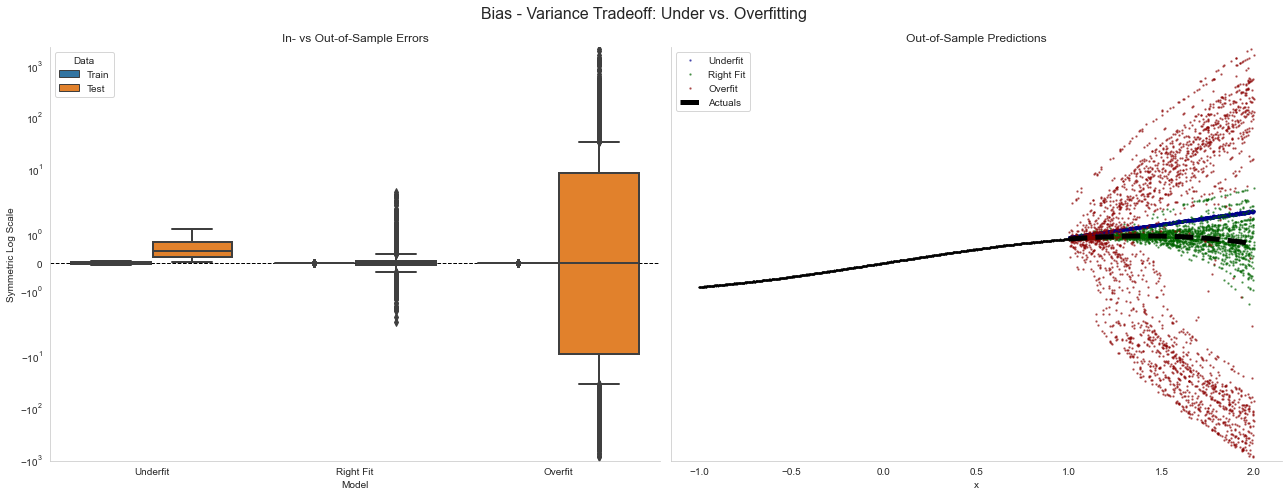

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 7), sharey=True)

sns.boxplot(x='Model', y='Error', hue='Data', data=result, ax=axes[0], linewidth=2)
axes[0].set_title('In- vs Out-of-Sample Errors')
axes[0].axhline(0, ls='--', lw=1, color='k')
axes[0].set_ylabel('Symmetric Log Scale')

for model in colors.keys():
    (test_data[(test_data['Model'] == model)]
     .plot.scatter(x='x',
                   y='y',
                   ax=axes[1],
                   s=2,
                   color=colors[model],
                   alpha=.5,
                   label=model))

# pd.Series(y['Train'], index=X['Train']).sort_index().plot(ax=axes[1], title='Out-of-sample Predictions')
pd.DataFrame(dict(x=X['Train'], y=y['Train_noise'])).plot.scatter(x='x', y='y', ax=axes[1], c='k', s=1)
pd.Series(y['Test'], index=X['Test']).plot(color='black', lw=5, ls='--', ax=axes[1], label='Actuals')

axes[0].set_yscale('symlog')
axes[1].set_title('Out-of-Sample Predictions')
axes[1].legend()
axes[0].grid(False)
axes[1].grid(False)
sns.despine()
fig.tight_layout()
fig.suptitle('Bias - Variance Tradeoff: Under vs. Overfitting', fontsize=16)
fig.subplots_adjust(top=0.9)

<div class="alert alert-info">
<font color=black>

- The **left-hand panel** shows the distribution of the errors that result from subtracting the true function values from the predictions. The high bias but low variance of an underfit polynomial of degree 1 compares to the low bias but exceedingly high variance of the errors for an overfitting polynomial of degree 15. The underfit polynomial produces a straight line with a poor in-sample fit that is significantly off-target out of sample. The overfit model shows the best fit in-sample with the smallest dispersion of errors, but the price is a large variance out-of-sample. The appropriate model that matches the functional form of the true model performs, on average, by far the best on out-of-sample data.

- The **right-hand panel** shows the actual predictions rather than the errors to visualize the different types of fit in practice:

</font>
</div>

## Learning Curves

In [10]:
def folds(train, test, nfolds):
    shuffle(train)
    shuffle(test)
    
    steps = (np.array([len(train), len(test)]) / nfolds).astype(int)
    for fold in range(nfolds):
        i, j = fold * steps
        yield train[i:i + steps[0]], test[j: j+steps[1]]

In [11]:
def rmse(y, x, model):
    return np.sqrt(mean_squared_error(y_true=y, y_pred=model.predict(x)))

In [12]:
def create_poly_data(data, degree):
    return np.hstack((data.reshape(-1, 1) ** i) for i in range(degree + 1))

In [13]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * .2
test_set =  X['Test'].copy()  

sample_sizes = np.arange(.1, 1.0, .01)
indices = ([len(train_set), len(test_set)] *
           sample_sizes.reshape(-1, 1)).astype(int)
result = []
lr = LinearRegression()
for label, degree in models.items():
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices:
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 5):
            y_train, y_test = f(x_train[:, 1]), f(x_test[:, 1])
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result.append([label, train_idx,
                       np.mean(train_rmse), np.std(train_rmse),
                       np.mean(test_rmse), np.std(test_rmse)])

result = (pd.DataFrame(result,
                       columns=['Model', 'Train Size',
                                'Train RMSE', 'Train RMSE STD',
                                'Test RMSE', 'Test RMSE STD'])
          .set_index(['Model', 'Train Size']))

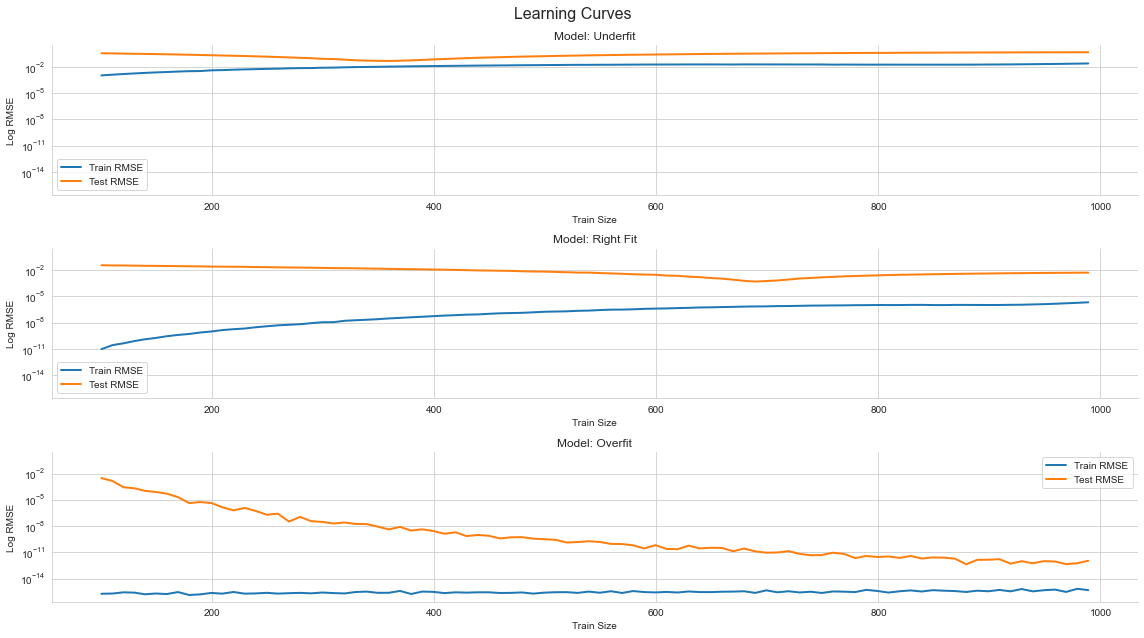

In [14]:
fig, axes = plt.subplots(nrows=3, sharey=True, figsize=(16, 9))
for i, model in enumerate(models.keys()):
    result.loc[model, ['Train RMSE', 'Test RMSE']].plot(ax=axes[i], title=f'Model: {model}', logy=True, lw=2)
    axes[i].set_ylabel('Log RMSE')

fig.suptitle('Learning Curves', fontsize=16)
fig.tight_layout()
sns.despine()
fig.subplots_adjust(top=.92);

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/06_machine_learning_process/03_bias_variance.ipynb
- Jansen, Stefan. Hands-On Machine Learning for Algorithmic Trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Packt Publishing Ltd, 2018.

</font>
</div>    